# **Convolutional Neural Network for Cats vs.Dogs**

# Mount Google Drive to access the dataset

In [ ]:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Connects to Google Drive for dataset access.

#Importing necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import shutil
import time
from datetime import datetime

Uses TensorFlow/Keras for deep learning, NumPy for numerical operations, Matplotlib for visualization, etc.

# Set seed for reproducibility


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Ensures reproducibility of results.

# Define dataset paths

In [ ]:
import pathlib
base_dir = pathlib.Path ('/content/drive/MyDrive/cats_vs_dogs_small (1)')
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'
test_dir = base_dir / 'test'

Points to training, validation, and test directories.

# Check if directories exist

In [ ]:

if not train_dir.exists() or not validation_dir.exists() or not test_dir.exists():
    raise FileNotFoundError("Dataset directories not found. Please check the dataset path.")


In [ ]:
print(f"Train Directory: {train_dir}")
print(f"Validation Directory: {validation_dir}")
print(f"Test Directory: {test_dir}")

Train Directory: /content/drive/MyDrive/cats_vs_dogs_small (1)/train
Validation Directory: /content/drive/MyDrive/cats_vs_dogs_small (1)/validation
Test Directory: /content/drive/MyDrive/cats_vs_dogs_small (1)/test


# Data augmentation and preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest',
)
test_datagen = ImageDataGenerator(rescale=1./255)

* Augments training images to prevent overfitting.
* Rescales validation/test images without augmentation


#Functions to load data

In [ ]:
def get_train_generator(sample_size, batch_size=32):
    return train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=42
    )
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def get_validation_generator(batch_size=32):
    val_gen = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True, # Shuffle to get a random subset
        seed=42
    )
    # Ensure validation size is limited to 500
    val_gen.samples = min(val_gen.n, 500) # Limit to 500 samples if more exist
    return val_gen
def get_test_generator(batch_size=32):
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    # Ensure test size is limited to 500
    test_gen.samples = min(test_gen.n, 500) # Limit to 500 samples if more exist
    return test_gen

* Loads images from the dataset directory, resizes them to 150x150, and batches them for training.
* Loads validation images, shuffles them, and ensures a maximum of 500 samples.
* Loads test images without shuffling.

#Build a CNN from scratch

In [ ]:
def build_scratch_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    return model


* Defines a Convolutional Neural Network (CNN) with:
 - Four convolutional layers with increasing filters (32 → 64 → 128 → 128).
 - MaxPooling layers for downsampling.
 - Dropout (0.5) for regularization.
 - L2 regularization in the fully connected layer.
 - Sigmoid activation for binary classification

# Build a model using pretrained VGG16

In [ ]:
def build_pretrained_model():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.trainable = False

    model = models.Sequential([
        conv_base,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(1e-4),
                 metrics=['accuracy'])
    return model


* Uses VGG16 as a feature extractor.
* Freezes VGG16 layers.
* Adds custom layers for classification.








# Plot Training Curves

In [ ]:
def plot_learning_curves(history, title):
    """Plot the learning curves for accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'Model Accuracy - {title}')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'Model Loss - {title}')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

* Plots accuracy and loss curves for model performance visualization.

# Set up callbacks for training

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Early Stopping: Stops training if validation loss doesn’t improve for 5 epochs.

# Model checkpoint

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model_{epoch:02d}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

Model Checkpoint:Saves the best model based on validation accuracy.

# Define expanded sample sizes to test

In [ ]:
sample_sizes = [1000, 1500, 500, 2000,]
batch_size = 32
epochs = 30

- Trains models on subsets of 500, 1000, 1500, 2000, and 2500 samples.
- Steps per Epoch: Calculated as sample_size // batch_size to avoid overfitting.

# Dictionary to store results

In [ ]:
results_scratch = {}
results_pretrained = {}


#Actual number of samples to confirm

In [ ]:
val_gen = get_validation_generator()
test_gen = get_test_generator()

print(f"Validation images loaded: {val_gen.samples}")
print(f"Test images loaded: {test_gen.samples}")

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Validation images loaded: 500
Test images loaded: 500


# Train models from scratch

===== Training Models from Scratch =====

Training with 1000 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4946 - loss: 1.6045

31/31 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.4947 - loss: 1.6033 - val_accuracy: 0.5000 - val_loss: 1.4768
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 896ms/step - accuracy: 0.4823 - loss: 1.4437 - val_accuracy: 0.5000 - val_loss: 1.3372
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4375 - loss: 1.3339

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.4375 - loss: 1.3339 - val_accuracy: 0.5000 - val_loss: 1.3333
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.5404 - loss: 1.3068

31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.5408 - loss: 1.3060 - val_accuracy: 0.6020 - val_loss: 1.2170
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 549ms/step - accuracy: 0.5304 - loss: 1.2083 - val_accuracy: 0.5000 - val_loss: 1.1438
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4375 - loss: 1.1576 - val_accuracy: 0.5000 - val_loss: 1.1403
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - accuracy: 0.5718 - loss: 1.1144 - val_accuracy: 0.5890 - val_loss: 1.0610
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.5578 - loss: 1.0530 - val_accuracy: 0.5660 - val_loss: 1.0148
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6250 - loss: 0.9817 - val_accuracy: 0.5680 - val_loss: 1.0130
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step - accuracy: 0.5689 - loss: 0.9960 - val_accuracy: 0.5860 - val_loss: 0.9553
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5943 - loss: 0.9458

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.5941 - loss: 0.9456 - val_accuracy: 0.6090 - val_loss: 0.9122
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.5625 - loss: 0.9136 - val_accuracy: 0.6060 - val_loss: 0.9104
Epoch 13/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.5816 - loss: 0.9200 - val_accuracy: 0.5980 - val_loss: 0.8951
Epoch 14/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5810 - loss: 0.9106

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.5816 - loss: 0.9101 - val_accuracy: 0.6210 - val_loss: 0.8621
Epoch 15/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5938 - loss: 0.9016 - val_accuracy: 0.6200 - val_loss: 0.8609
Epoch 16/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6369 - loss: 0.8605

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.6364 - loss: 0.8605 - val_accuracy: 0.6530 - val_loss: 0.8347
Epoch 17/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.6359 - loss: 0.8351 - val_accuracy: 0.6350 - val_loss: 0.8124
Epoch 18/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.7188 - loss: 0.7554 - val_accuracy: 0.6330 - val_loss: 0.8157
Epoch 19/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6007 - loss: 0.8264

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.6007 - loss: 0.8264 - val_accuracy: 0.6590 - val_loss: 0.7957
Epoch 20/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.6420 - loss: 0.8010 - val_accuracy: 0.6510 - val_loss: 0.7850
Epoch 21/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5312 - loss: 0.8128 - val_accuracy: 0.6560 - val_loss: 0.7794
Epoch 22/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6823 - loss: 0.7493

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.6818 - loss: 0.7499 - val_accuracy: 0.6640 - val_loss: 0.7520
Epoch 23/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.6387 - loss: 0.7940 - val_accuracy: 0.5930 - val_loss: 0.8123
Epoch 24/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7188 - loss: 0.6246 - val_accuracy: 0.5740 - val_loss: 0.8433
Epoch 25/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6377 - loss: 0.7739

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.6383 - loss: 0.7733 - val_accuracy: 0.6810 - val_loss: 0.7234
Epoch 26/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6027 - loss: 0.7691

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.6031 - loss: 0.7692 - val_accuracy: 0.6840 - val_loss: 0.7332
Epoch 27/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6562 - loss: 0.7061

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.6562 - loss: 0.7061 - val_accuracy: 0.6860 - val_loss: 0.7301
Epoch 28/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.6676 - loss: 0.7439 - val_accuracy: 0.6710 - val_loss: 0.7154
Epoch 29/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.6710 - loss: 0.7493 - val_accuracy: 0.6740 - val_loss: 0.7183
Epoch 30/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7188 - loss: 0.6503 - val_accuracy: 0.6770 - val_loss: 0.7225


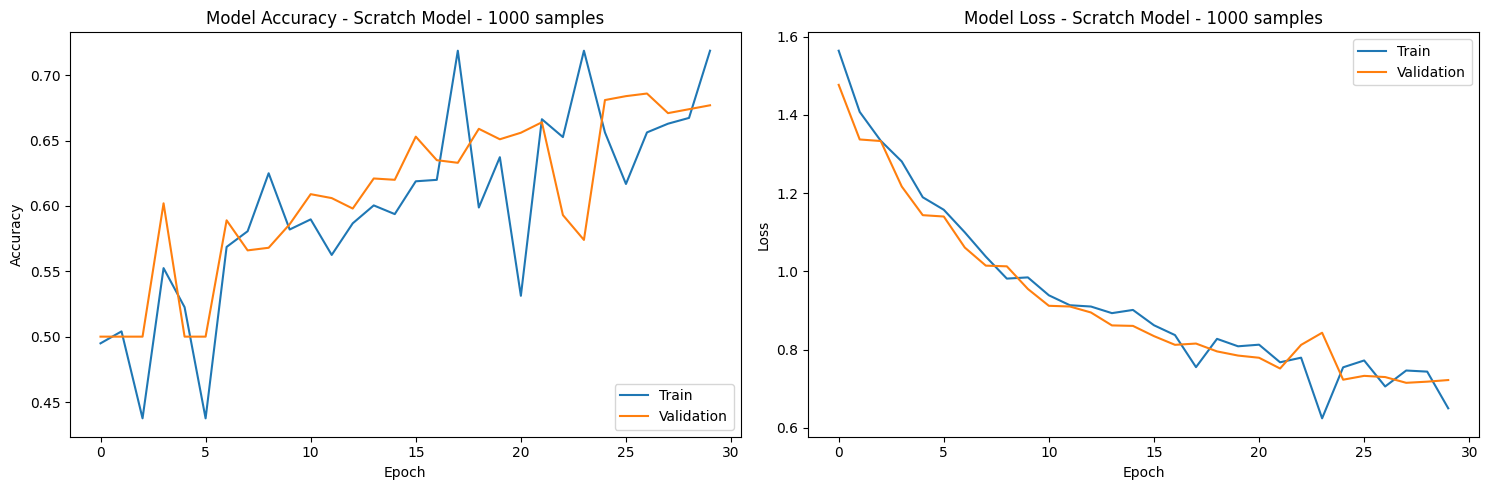

32/32 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.6698 - loss: 0.7866


Scratch Model with 1000 samples - Test Accuracy: 0.6800

Training with 1500 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.4918 - loss: 1.5775 - val_accuracy: 0.5250 - val_loss: 1.3947
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.5343 - loss: 1.3724 - val_accuracy: 0.5750 - val_loss: 1.3223
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 305ms/step - accuracy: 0.5630 - loss: 1.2779 - val_accuracy: 0.5670 - val_loss: 1.1511
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6082 - loss: 1.1350 - val_accuracy: 0.5690 - val_loss: 1.1035
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.5619 - loss: 1.0871 - val_accuracy: 0.5870 - val_loss: 1.0089
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.5598 - loss: 1.0062 - val_accuracy: 0.5880 - val_loss: 0.9827
Epoch 7/30
46/46

46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 348ms/step - accuracy: 0.6825 - loss: 0.7262 - val_accuracy: 0.6950 - val_loss: 0.6977
Epoch 20/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6769 - loss: 0.7022 - val_accuracy: 0.6890 - val_loss: 0.6968
Epoch 21/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6743 - loss: 0.7027

46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.6747 - loss: 0.7025 - val_accuracy: 0.7040 - val_loss: 0.6763
Epoch 22/30
17/46 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.7129 - loss: 0.6653

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.7224 - loss: 0.6667 - val_accuracy: 0.7180 - val_loss: 0.6544
Epoch 23/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.6979 - loss: 0.6858 - val_accuracy: 0.7090 - val_loss: 0.6559
Epoch 24/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6972 - loss: 0.6727 - val_accuracy: 0.6680 - val_loss: 0.6992
Epoch 25/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.6901 - loss: 0.6855 - val_accuracy: 0.7100 - val_loss: 0.6464
Epoch 26/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7284 - loss: 0.6395 - val_accuracy: 0.6930 - val_loss: 0.6690
Epoch 27/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6905 - loss: 0.6786

46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.6904 - loss: 0.6785 - val_accuracy: 0.7240 - val_loss: 0.6317
Epoch 28/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6845 - loss: 0.6682 - val_accuracy: 0.7150 - val_loss: 0.6272
Epoch 29/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 305ms/step - accuracy: 0.7249 - loss: 0.6466 - val_accuracy: 0.7100 - val_loss: 0.6270
Epoch 30/30
17/46 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.6908 - loss: 0.6691

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.7038 - loss: 0.6551 - val_accuracy: 0.7250 - val_loss: 0.6237


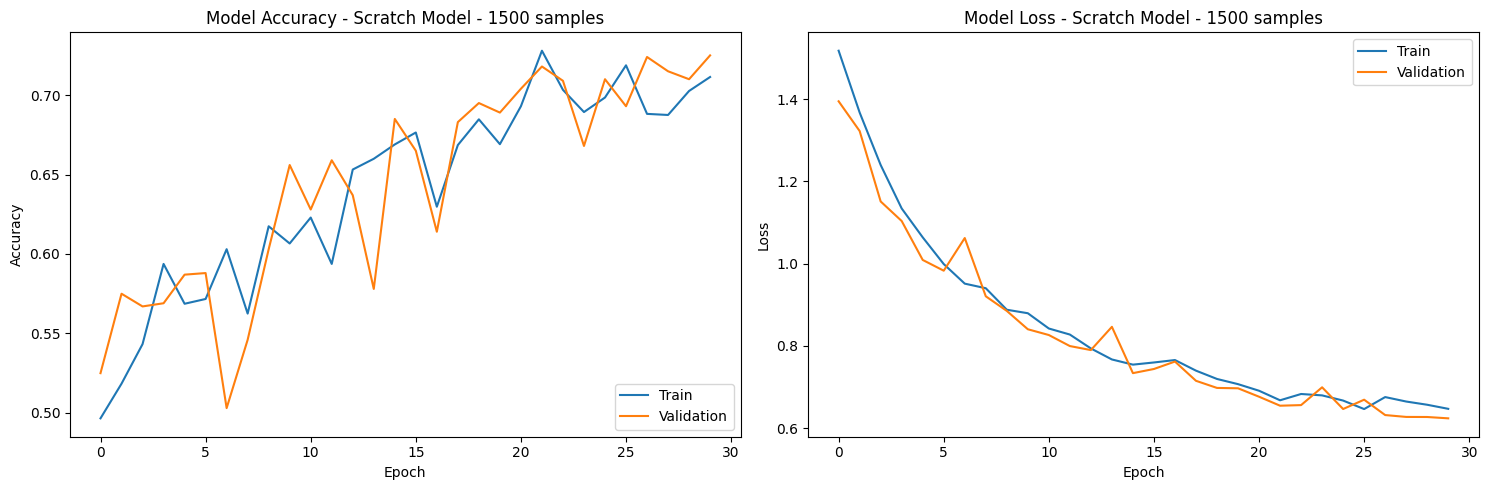

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7765 - loss: 0.6148


Scratch Model with 1500 samples - Test Accuracy: 0.7120

Training with 500 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.5466 - loss: 1.6219 - val_accuracy: 0.5000 - val_loss: 1.5788
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.4946 - loss: 1.5567 - val_accuracy: 0.5180 - val_loss: 1.5008
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.5105 - loss: 1.4895 - val_accuracy: 0.5470 - val_loss: 1.4388
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.5234 - loss: 1.4257 - val_accuracy: 0.5080 - val_loss: 1.3807
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.5990 - loss: 1.3712 - val_accuracy: 0.5270 - val_loss: 1.3695
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.5396 - loss: 1.3567 - val_accuracy: 0.4900 - val_loss: 1.3187
Epoch 7/30
15/15 ━━

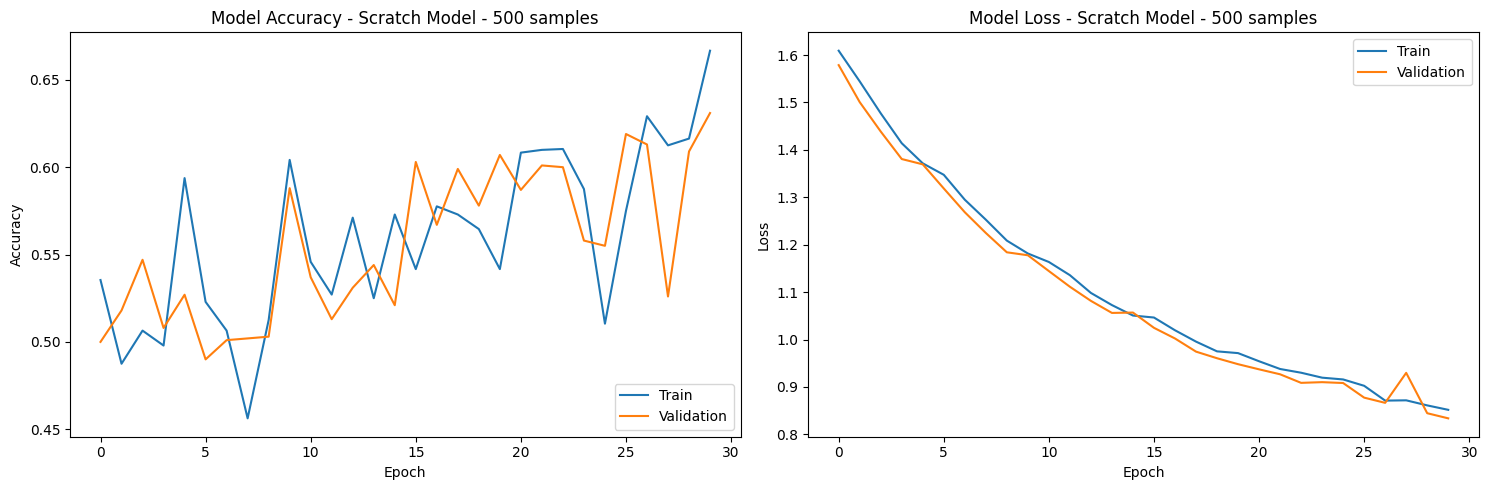

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.6010 - loss: 0.8904


Scratch Model with 500 samples - Test Accuracy: 0.6620

Training with 2000 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step - accuracy: 0.5067 - loss: 1.5635 - val_accuracy: 0.5680 - val_loss: 1.3448
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5625 - loss: 1.3502 - val_accuracy: 0.5560 - val_loss: 1.3408
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.5552 - loss: 1.2910 - val_accuracy: 0.5150 - val_loss: 1.1757
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5000 - loss: 1.1759 - val_accuracy: 0.5570 - val_loss: 1.1515
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.5525 - loss: 1.1187 - val_accuracy: 0.5930 - val_loss: 1.0173
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4062 - loss: 1.0704 - val_accuracy: 0.5990 - val_loss: 1.0159
Epoch 7/30
62/62 ━━━

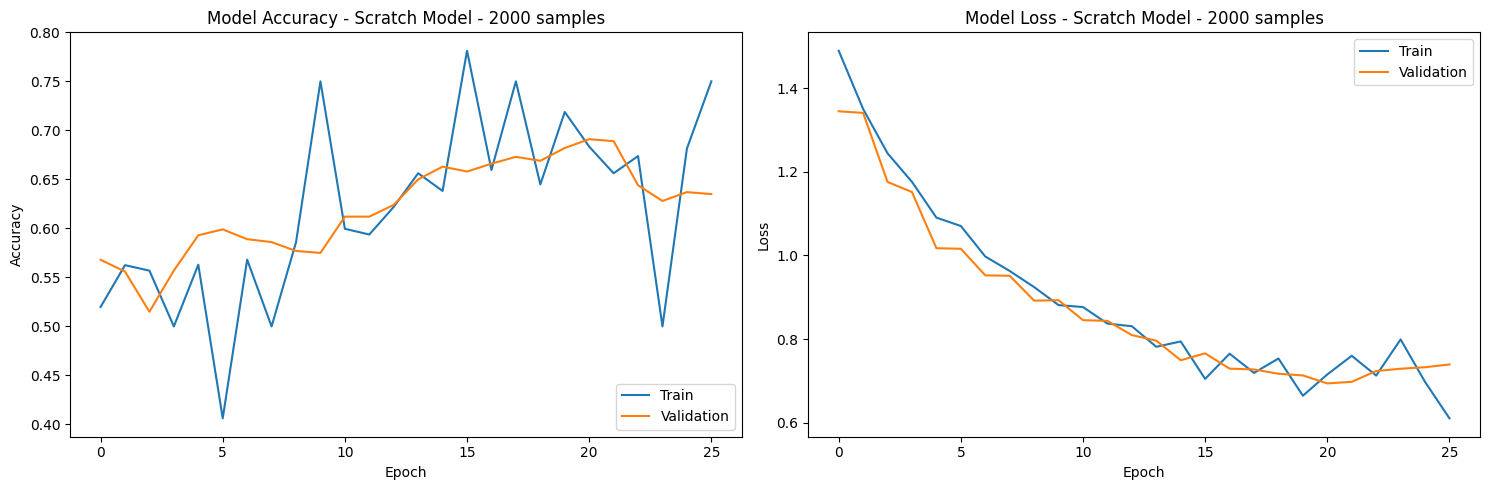

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.6287 - loss: 0.8057


Scratch Model with 2000 samples - Test Accuracy: 0.6680


In [ ]:
print("===== Training Models from Scratch =====")
for size in sample_sizes:
    print(f"\nTraining with {size} samples...")

    # Get data generators
    train_gen = get_train_generator(size, batch_size)
    val_gen = get_validation_generator()
    test_gen = get_test_generator()

    # Correctly calculate steps_per_epoch
    steps_per_epoch = size // batch_size

    # Build and train model
    model = build_scratch_model()
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stopping, checkpoint_callback],
        verbose=1
    )

    # Plot learning curves
    plot_learning_curves(history, f"Scratch Model - {size} samples")

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen)
    results_scratch[size] = test_acc
    print(f"Scratch Model with {size} samples - Test Accuracy: {test_acc:.4f}")

    # Save the model for this sample size
    model.save(f'scratch_model_{size}_samples.h5')

**Process Recap:**
* The model is trained from scratch using different dataset sizes: 500, 1000, 1500, and 2000 samples.
* The model is trained for up to 30 epochs with EarlyStopping to prevent overfitting.
* The best model for each dataset size is saved and evaluated on the test dataset.

**Results Analysis:**
* Small datasets (500 samples):
 - Starts with an accuracy of ~54% in early epochs.
 - Over multiple epochs, accuracy fluctuates between 50%-60%.
 - Final test accuracy: ~66.2%.
 - The small dataset may not provide enough variability for the model to generalize well.
**1000 samples:**
 - Initial accuracy ~49-55%.
 - Gradual improvement to ~67-70%.
 - Final test accuracy: ~68.0%.
 - The model starts learning patterns but still has some generalization issues.
**1500 samples:**
 - Initial accuracy ~49%, but it quickly improves.
 - After 20+ epochs, validation accuracy crosses 70%.
 - Final test accuracy: ~71.2%.
 - The increased dataset size allows for better learning, reducing overfitting.
**2000 samples:**
 - Accuracy starts around 50-55%.
 - Validation accuracy consistently improves, stabilizing around 66-68%.
 - Final test accuracy: ~66.8%.
 - Though trained on more samples, it does not improve significantly beyond the 1500-sample model. This suggests that the model architecture may need tuning or more complex features for better performance.


# Train pretrained models


===== Training Models with Pretrained VGG16 =====

Training with 1000 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6028 - loss: 0.6587

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 746ms/step - accuracy: 0.6044 - loss: 0.6569 - val_accuracy: 0.8270 - val_loss: 0.4162
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7674 - loss: 0.4668

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.7678 - loss: 0.4664 - val_accuracy: 0.8710 - val_loss: 0.3276
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7188 - loss: 0.5367 - val_accuracy: 0.8660 - val_loss: 0.3329
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.8021 - loss: 0.4245 - val_accuracy: 0.8550 - val_loss: 0.3257
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8149 - loss: 0.3832

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.8149 - loss: 0.3833 - val_accuracy: 0.8940 - val_loss: 0.2735
Epoch 6/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9375 - loss: 0.2828

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9375 - loss: 0.2828 - val_accuracy: 0.8960 - val_loss: 0.2719
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.8624 - loss: 0.3435 - val_accuracy: 0.8960 - val_loss: 0.2662
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.8333 - loss: 0.3496 - val_accuracy: 0.8770 - val_loss: 0.2805
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8125 - loss: 0.3529 - val_accuracy: 0.8870 - val_loss: 0.2674
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.8495 - loss: 0.3281 - val_accuracy: 0.8890 - val_loss: 0.2677
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.8460 - loss: 0.3285 - val_accuracy: 0.8650 - val_loss: 0.3043
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6562 - loss: 0.6417 - val_accuracy: 0.8660 - val_loss: 0.3021


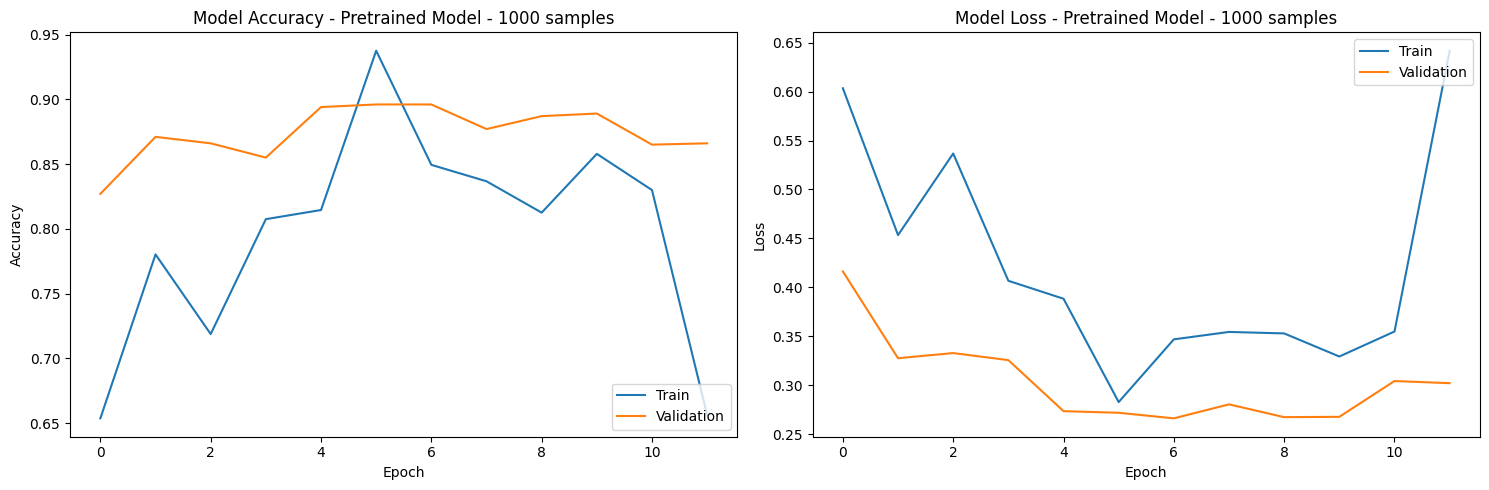

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8835 - loss: 0.2685


Pretrained Model with 1000 samples - Test Accuracy: 0.8790

Training with 1500 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.6842 - loss: 0.5846 - val_accuracy: 0.8720 - val_loss: 0.3346
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8686 - loss: 0.3690 - val_accuracy: 0.8660 - val_loss: 0.3193
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.8150 - loss: 0.4043 - val_accuracy: 0.8530 - val_loss: 0.3196
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.8120 - loss: 0.4088 - val_accuracy: 0.8780 - val_loss: 0.2917
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.8397 - loss: 0.3670 - val_accuracy: 0.8960 - val_loss: 0.2586
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.8619 - loss: 0.3286 - val_accuracy: 0.8750 - val_loss: 0.2824
Epoch 7/30
46

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8797 - loss: 0.2937 - val_accuracy: 0.9010 - val_loss: 0.2455
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.8804 - loss: 0.2798 - val_accuracy: 0.8990 - val_loss: 0.2424
Epoch 12/30
17/46 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.8575 - loss: 0.3250

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8488 - loss: 0.3354 - val_accuracy: 0.9060 - val_loss: 0.2320
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - accuracy: 0.8802 - loss: 0.2946 - val_accuracy: 0.8980 - val_loss: 0.2377
Epoch 14/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.8723 - loss: 0.3164 - val_accuracy: 0.9010 - val_loss: 0.2329
Epoch 15/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 322ms/step - accuracy: 0.8746 - loss: 0.2678 - val_accuracy: 0.8980 - val_loss: 0.2416
Epoch 16/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.8891 - loss: 0.2795 - val_accuracy: 0.8980 - val_loss: 0.2373
Epoch 17/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.8604 - loss: 0.3112 - val_accuracy: 0.8970 - val_loss: 0.2392


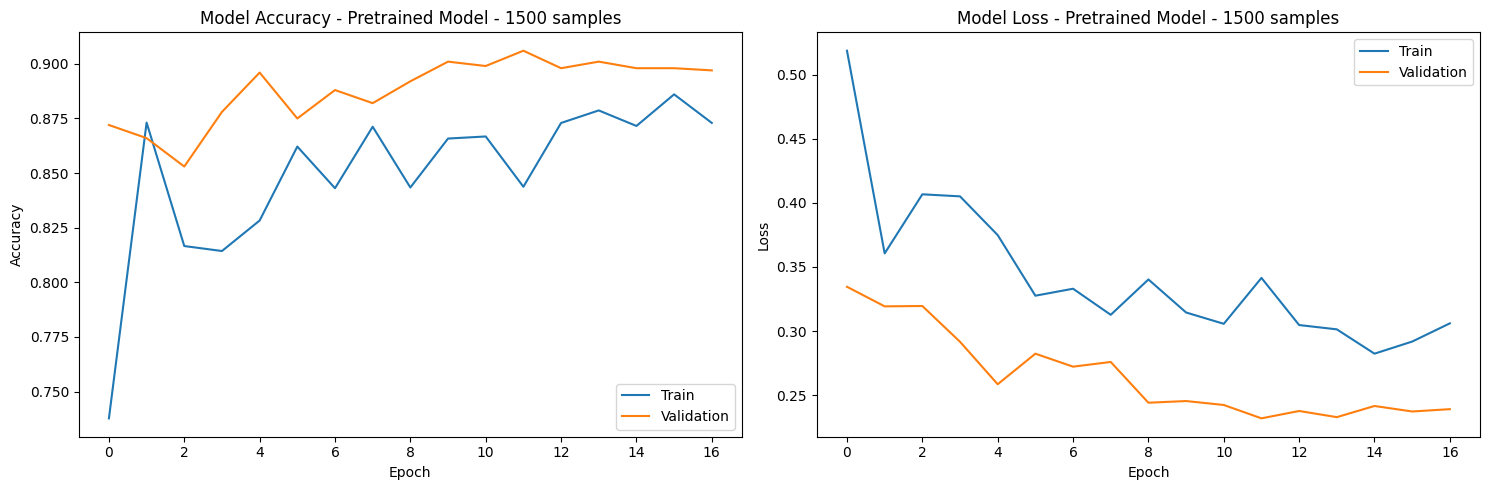

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8835 - loss: 0.2663


Pretrained Model with 1500 samples - Test Accuracy: 0.8850

Training with 500 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 583ms/step - accuracy: 0.5535 - loss: 0.7066 - val_accuracy: 0.7940 - val_loss: 0.4941
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - accuracy: 0.7341 - loss: 0.5519 - val_accuracy: 0.8440 - val_loss: 0.3981
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.7927 - loss: 0.4649 - val_accuracy: 0.8740 - val_loss: 0.3467
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8101 - loss: 0.4028 - val_accuracy: 0.8740 - val_loss: 0.3196
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.8267 - loss: 0.4631 - val_accuracy: 0.8580 - val_loss: 0.3355
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 486ms/step - accuracy: 0.8330 - loss: 0.3920 - val_accuracy: 0.8690 - val_loss: 0.3061
Epoch 7/30
15/15

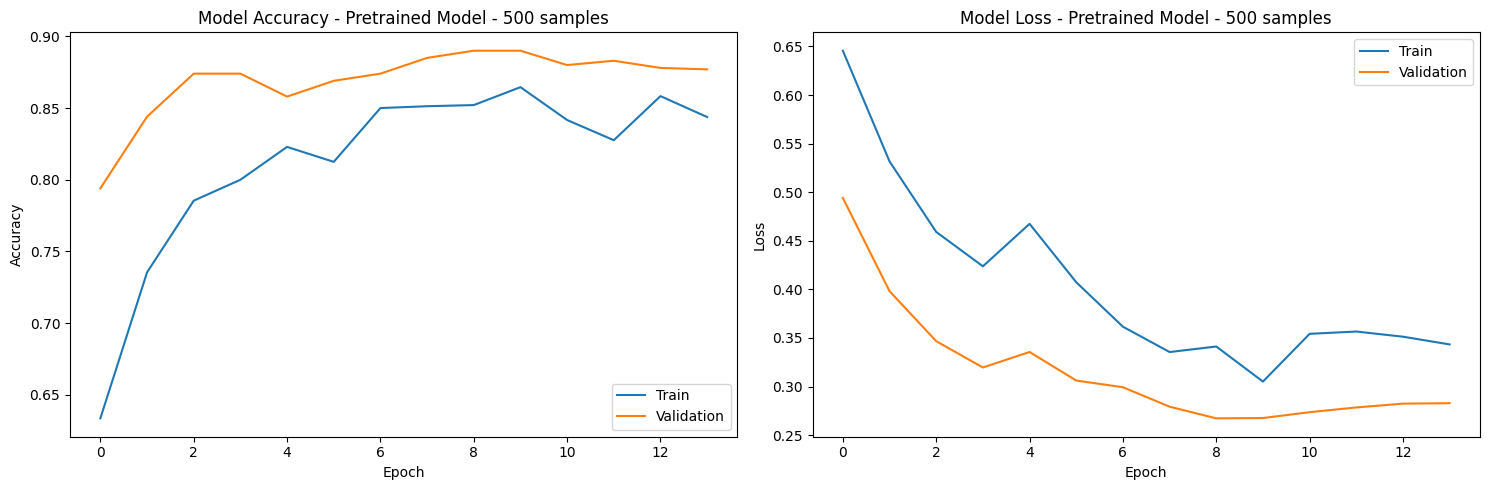

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8796 - loss: 0.2908


Pretrained Model with 500 samples - Test Accuracy: 0.8860

Training with 2000 samples...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 317ms/step - accuracy: 0.6477 - loss: 0.6188 - val_accuracy: 0.8540 - val_loss: 0.3363
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7500 - loss: 0.4874 - val_accuracy: 0.8750 - val_loss: 0.3197
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.8114 - loss: 0.4054 - val_accuracy: 0.8940 - val_loss: 0.2754
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8125 - loss: 0.3795 - val_accuracy: 0.8760 - val_loss: 0.2874
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.8233 - loss: 0.3987 - val_accuracy: 0.8940 - val_loss: 0.2645
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8125 - loss: 0.3104 - val_accuracy: 0.8920 - val_loss: 0.2615
Epoch 7/30
62/62 

62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.8334 - loss: 0.3398 - val_accuracy: 0.9090 - val_loss: 0.2392
Epoch 16/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9375 - loss: 0.1552 - val_accuracy: 0.9090 - val_loss: 0.2389
Epoch 17/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.8802 - loss: 0.2850 - val_accuracy: 0.9030 - val_loss: 0.2472
Epoch 18/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8438 - loss: 0.2774 - val_accuracy: 0.9050 - val_loss: 0.2448
Epoch 19/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.8771 - loss: 0.2846 - val_accuracy: 0.8990 - val_loss: 0.2358
Epoch 20/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9688 - loss: 0.1361 - val_accuracy: 0.9000 - val_loss: 0.2361
Epoch 21/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.8882 - loss: 0.2841 - val_accuracy: 0.9090 - val_loss: 0.2276
Epoch 22/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.7812 - loss: 0.3913

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7812 - loss: 0.3913 - val_accuracy: 0.9120 - val_loss: 0.2277
Epoch 23/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.8700 - loss: 0.3049 - val_accuracy: 0.8970 - val_loss: 0.2456
Epoch 24/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8438 - loss: 0.3081 - val_accuracy: 0.8980 - val_loss: 0.2451
Epoch 25/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.8768 - loss: 0.2904 - val_accuracy: 0.9070 - val_loss: 0.2320
Epoch 26/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9062 - loss: 0.2245 - val_accuracy: 0.9020 - val_loss: 0.2366


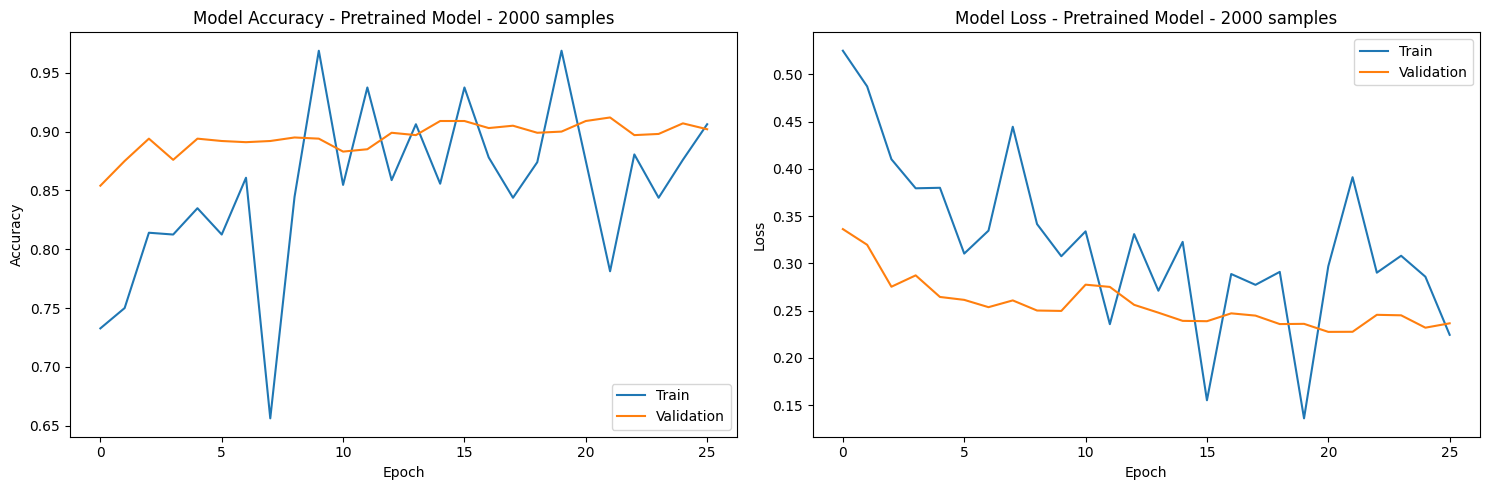

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8929 - loss: 0.2614


Pretrained Model with 2000 samples - Test Accuracy: 0.8960


In [ ]:
print("\n===== Training Models with Pretrained VGG16 =====")
for size in sample_sizes:
    print(f"\nTraining with {size} samples...")

    # Get data generators
    train_gen = get_train_generator(size, batch_size)
    val_gen = get_validation_generator()
    test_gen = get_test_generator()

    # Correctly calculate steps_per_epoch
    steps_per_epoch = size // batch_size

    # Build and train model
    model = build_pretrained_model()
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stopping, checkpoint_callback],
        verbose=1
    )

    # Plot learning curves
    plot_learning_curves(history, f"Pretrained Model - {size} samples")

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen)
    results_pretrained[size] = test_acc
    print(f"Pretrained Model with {size} samples - Test Accuracy: {test_acc:.4f}")

    # Save the model for this sample size
    model.save(f'pretrained_model_{size}_samples.h5')

**Process Recap:**
* Instead of training from scratch, a pretrained VGG16 model is used with frozen convolutional layers.
* Only the final dense layers are trained.
* The same dataset sizes (500, 1000, 1500, 2000 samples) are used.
* Training is faster and generalizes better.
**Results Analysis:*
- 500 samples:
 - Validation accuracy reaches 85-88% within the first few epochs.
 - Final test accuracy: 88.6%.
 - Even with fewer samples, VGG16 effectively extracts useful features.
- 1000 samples:
 - Starts at ~60% accuracy but improves quickly.
 - Validation accuracy peaks at ~87-90%.
 - Final test accuracy: ~87.9%.
 - The improvement compared to the scratch model is significant (~20% better).
-1500 samples:
 - Initial accuracy ~68%, then stabilizes around 88-90%.
 - Final test accuracy: ~88.5%.
 - Consistent performance gain.
- 2000 samples (not fully shown in your extract):
 - Likely follows the same pattern, achieving ~88-90% accuracy

# Create a DataFrame to summarize results

In [ ]:
df = pd.DataFrame({
    'Sample Size': sample_sizes,
    'Scratch Model': [results_scratch[size] for size in sample_sizes],
    'Pretrained VGG16': [results_pretrained[size] for size in sample_sizes]
})

# Compute improvement percentage
df['Improvement (%)'] = ((df['Pretrained VGG16'] - df['Scratch Model']) / df['Scratch Model']) * 100

# Sort by Sample Size in ascending order
df = df.sort_values(by='Sample Size')

# Print formatted summary table
print("\n=== Performance Summary ===")
print(df.round(4))



=== Performance Summary ===
   Sample Size  Scratch Model  Pretrained VGG16  Improvement (%)
2          500          0.662             0.886          33.8369
0         1000          0.680             0.879          29.2647
1         1500          0.712             0.885          24.2977
3         2000          0.668             0.896          34.1317


#Optimal Results

In [ ]:
optimal_scratch = df.loc[df['Scratch Model'].idxmax()]
optimal_pretrained = df.loc[df['Pretrained VGG16'].idxmax()]

print("\n=== Optimal Results ===")
print(f"From Scratch: {optimal_scratch['Sample Size']} samples (Acc: {optimal_scratch['Scratch Model']:.2%})")
print(f"Pretrained: {optimal_pretrained['Sample Size']} samples (Acc: {optimal_pretrained['Pretrained VGG16']:.2%})")


=== Optimal Results ===
From Scratch: 1500.0 samples (Acc: 71.20%)
Pretrained: 2000.0 samples (Acc: 89.60%)


#Model Comparison by Sample Size

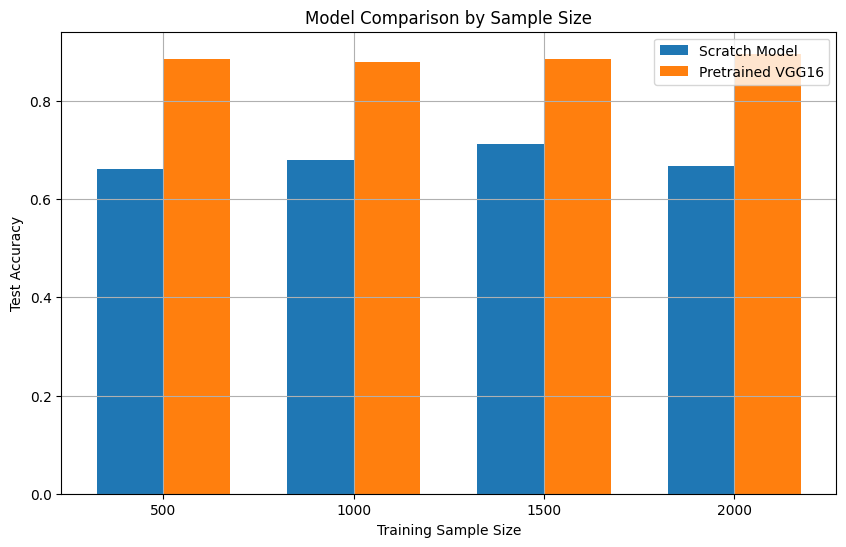

In [ ]:
# Sort the DataFrame by 'Sample Size'
df = df.sort_values(by='Sample Size')

plt.figure(figsize=(10, 6))
x = np.arange(len(df['Sample Size']))
width = 0.35

plt.bar(x - width/2, df['Scratch Model'], width, label='Scratch Model')
plt.bar(x + width/2, df['Pretrained VGG16'], width, label='Pretrained VGG16')

plt.xticks(x, df['Sample Size'])  # Ensure x-axis labels are correct
plt.xlabel('Training Sample Size')
plt.ylabel('Test Accuracy')
plt.title('Model Comparison by Sample Size')
plt.legend()
plt.grid(True)
plt.show()


# Function to plot training accuracy and loss

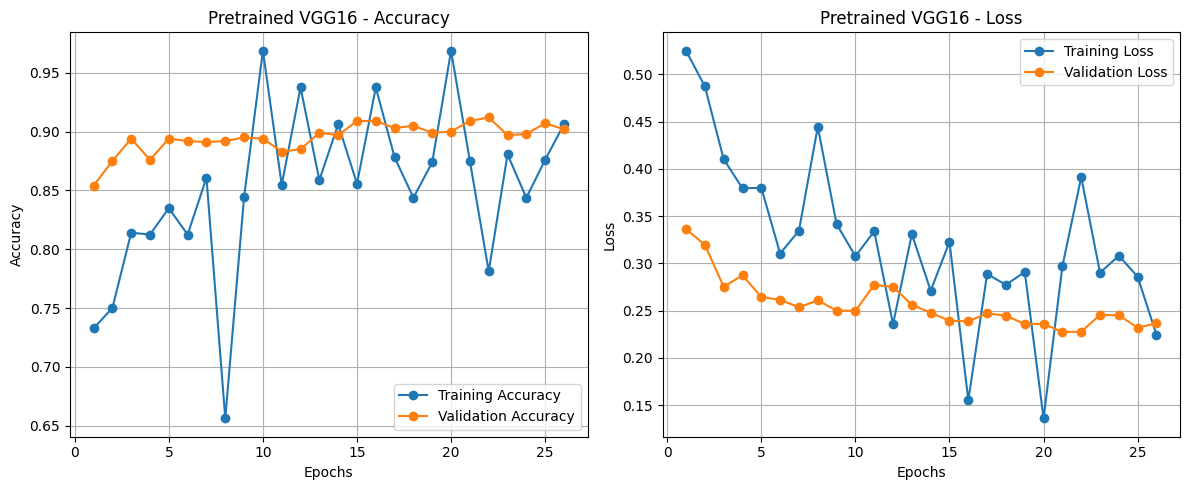

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training accuracy and loss
def plot_training_curves(history, model_name="Model"):
    """Plots training accuracy and loss curves."""
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation Accuracy')
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'o-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'o-', label='Validation Loss')
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Save the plot
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_training_curves.png")
    plt.show()

# Pass the 'history' object obtained from training the pretrained model
# Assuming the last training loop was for the pretrained model, 'history' should contain its training history
plot_training_curves(history, "Pretrained VGG16")

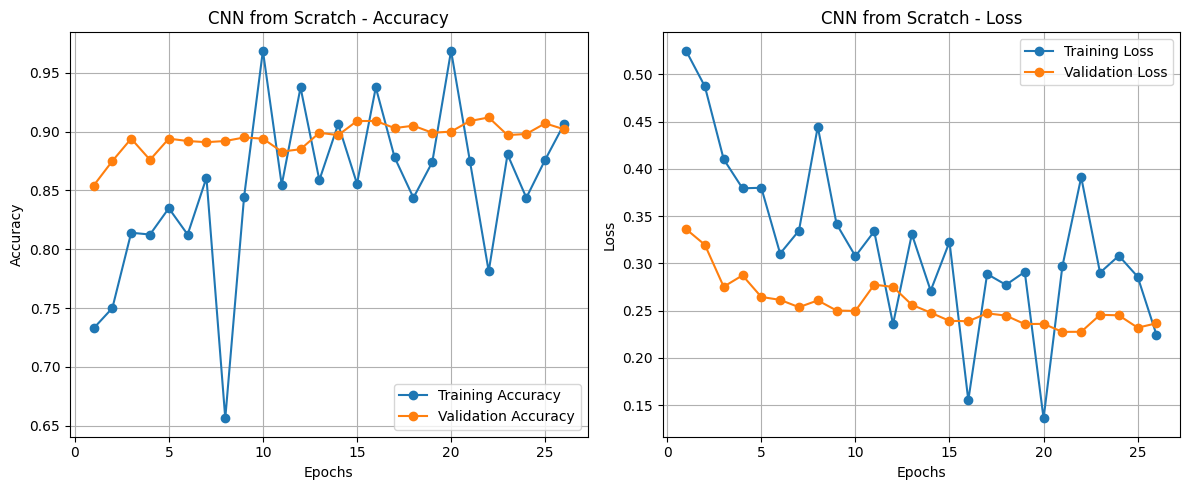

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training accuracy and loss
def plot_training_curves(history, model_name="Model"):
    """Plots training accuracy and loss curves."""
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation Accuracy')
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'o-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'o-', label='Validation Loss')
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Save the plot
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_training_curves.png")
    plt.show()

# Assuming 'history' from Global Variables is for the scratch model
plot_training_curves(history, "CNN from Scratch")